# Mixed Effects Models   

https://www.kaggle.com/ojwatson/mixed-models

Веб-сайт попросил нас выяснить, могут ли молодые люди с большей вероятностью покинуть веб-сайт быстрее.

In [1]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# 1. Взаимодействие с данными

In [2]:
# read in our data
data = pd.read_csv('/home/vera/Учеба/Mixed_effects_M/data.csv')
data.head(30)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a
5,168.688747,47,devon,a
6,169.619382,7,devon,a
7,164.416273,8,devon,a
8,167.510430,8,devon,a
9,179.606068,7,devon,a


bounce times - время ухода с сайта

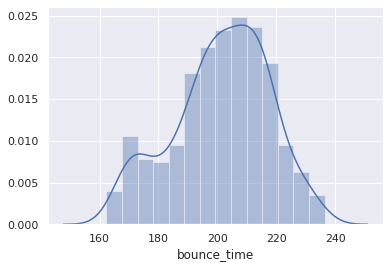

In [3]:
# plot the distribution of the bounce times - this creates the object that will be plotted when matplotlib.pyplot
sns.distplot(data.bounce_time)
plt.show()

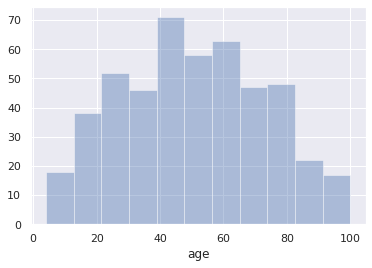

In [4]:
# plot the distribution of the ages
sns.distplot(data.age, kde=False) #kde - проводит линию по гистограмме
plt.show()

Прежде чем мы продолжим, часто рекомендуется масштабировать наши независимые переменные так, чтобы они были стандартизированы. Это полезно, поскольку это означает, что любой предполагаемый коэффициент из нашей регрессионной модели в дальнейшем будет иметь одинаковую шкалу. Итак, для нашего набора данных это будет возраст, и давайте создадим новую переменную age_scaled, которая будет масштабироваться так, чтобы среднее значение равнялось нулю, а дисперсия - единице:

In [5]:
# lets use the scale function from the preprocess package within sklearn
from sklearn import preprocessing
data["age_scaled"] = preprocessing.scale(data.age.values)

In [6]:
data.head()

,bounce_time,age,county,location,age_scaled
0,165.548520,16,devon,a,-1.512654
1,167.559314,34,devon,a,-0.722871
2,165.882952,6,devon,a,-1.951423
3,167.685525,19,devon,a,-1.381024
4,169.959681,34,devon,a,-0.722871


Это масштабирование не повлияет на статистические результаты в нашем примере, но вы можете обнаружить, что в более сложных моделях, чем в этом руководстве, это может быть очень полезно для ускорения подбора моделей. Это также делает сравнение между непрерывной переменной, такой как age, и двоичной переменной (0, 1) более справедливым. 

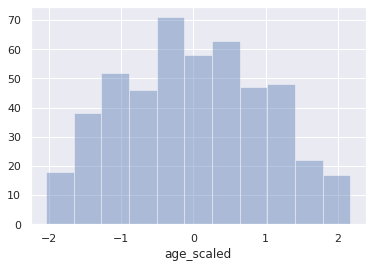

In [7]:
# plot the distribution
sns.distplot(data.age_scaled, kde=False)
plt.show()

# 2. Linear Regression

Первое, что мы могли бы сделать, чтобы увидеть, зависит ли время отказов от возраста, - построить эти данные, а затем подогнать их под линейную регрессию:

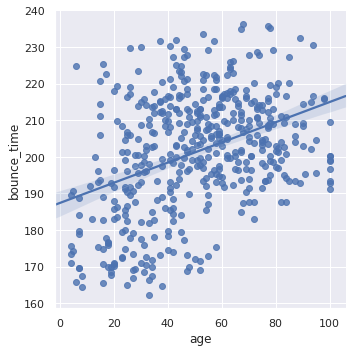

In [8]:
# let's use the lmplot function within seaborn
sns.lmplot(x = "age", y = "bounce_time", data = data)

In [9]:
from sklearn.linear_model import LinearRegression

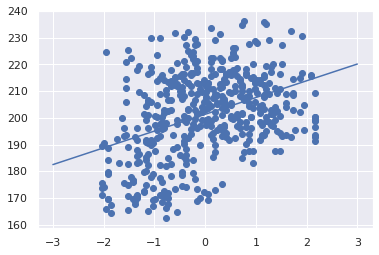

In [10]:
# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data.age_scaled
y = data.bounce_time

# fit our model to the data
model.fit(x[:, np.newaxis], y)

# and let's plot what this relationship looks like 
xfit = np.linspace(-3, 3, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

In [11]:
print("Model slope:    ", model.coef_[0]) #b1
print("Model intercept:", model.intercept_) #b0

Model slope:     6.279602007970821
Model intercept: 201.31646151854164


In [12]:
# and let's store the rmse
#RMSE (Root Mean Square Error) - Среднеквадратичная ошибка
y_predict = model.predict(x.values.reshape(-1,1))
RMSE = sqrt(((y-y_predict)**2).values.mean())

In [13]:
results = pd.DataFrame()
results["Method"] = ["Linear Regression"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Linear Regression,14.928334


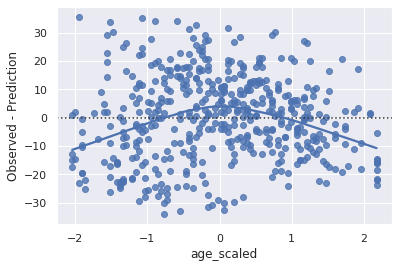

In [14]:
ax = sns.residplot(x = "age_scaled", y= "bounce_time", data = data, lowess = True)
ax.set(ylabel='Observed - Prediction')
plt.show()

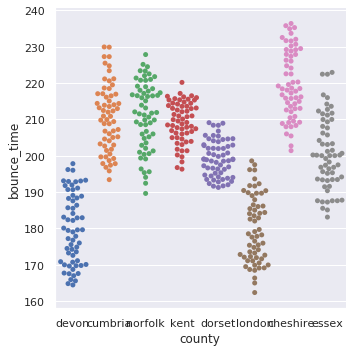

In [15]:
sns.catplot(x="county", y="bounce_time", data=data, kind = "swarm")

что есть существенная группировка - у нас, лондонцев, кажется, короткий охват внимания (возможно ...). Таким образом, мы можем с уверенностью сказать, что наши данные не являются независимыми, и поэтому неуместно использовать линейную модель для этих данных.

Что дальше? Ну, может быть, мы могли бы сделать отдельную регрессию для каждого округа.

# 3a. Separate Linear Regression

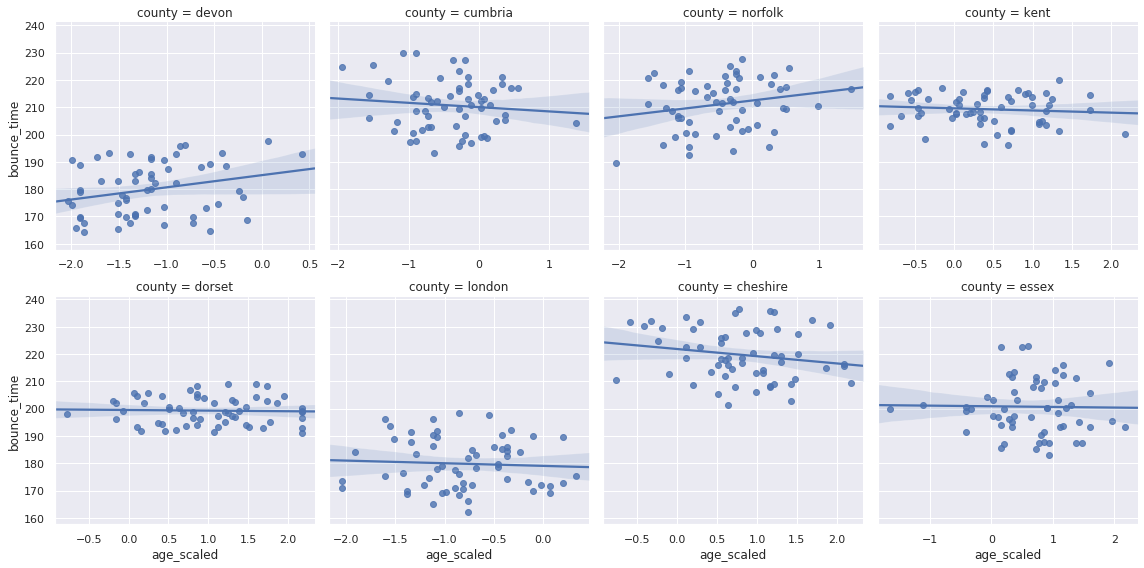

In [16]:
# let's use the lmplot function within seaborn
grid = sns.lmplot(x = "age_scaled", y = "bounce_time", col = "county", sharex=False, col_wrap = 4, data = data, height=4)

Итак, теперь у нас есть 8 различных анализов. Это хорошо, но в результате мы уже начали значительно уменьшать размер выборки, и теперь мы, возможно, зашли слишком далеко в другом направлении. Раньше мы говорили, что все округа были идентичны, тогда как здесь мы говорим, что влияние возраста на bounce_time не имеет сходства между округами, что, вероятно, опять-таки не соответствует действительности.

Кроме того, что касается нашей переменной местоположения, возможно, наши данные также не являются независимыми при просмотре местоположения. Давайте посмотрим на это тоже, используя  swarm plot:

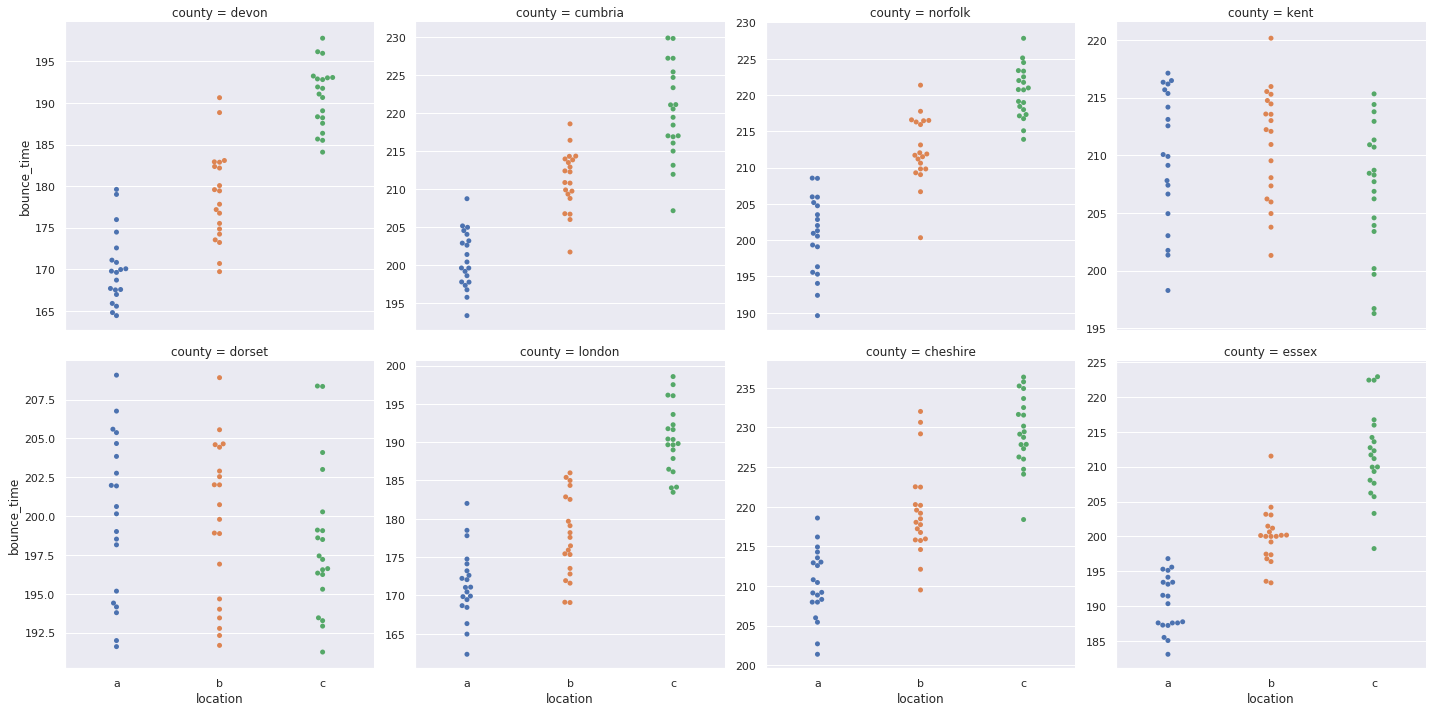

In [17]:
sns.catplot(x="location", y="bounce_time", col="county", col_wrap=4, sharey=False, data=data, kind = "swarm")

Таким образом, мы могли бы продолжить, а затем провести индивидуальную регрессию для каждого местоположения в каждом округе ... надеюсь, вы понимаете, почему мы не всегда можем просто сделать индивидуальную регрессию для каждой новой группы. Если бы мы это сделали, нам пришлось бы оценивать наклон и параметр перехвата для каждой регрессии. Это два параметра, три местоположения и восемь округов, что означает 48 оценок параметров (2 x 3 x 8 = 48).   

Кроме того, теперь мы возьмем наш хороший набор данных из 480 наблюдений, который, по-видимому, потребовал много времени для сбора, и эффективно сократили его до большого количества выборок по 20. Это действительно уменьшает нашу статистическую мощность и, таким образом, также увеличивает наши шансы на тип. Ошибка (когда вы ложно отвергаете нулевую гипотезу), выполняя множественные сравнения.  

Так что мы могли сделать? Ну, мы могли бы изменить модель для учета различных округов и добавить ее в нашу линейную модель.

# 3b. Modelling county as a fixed effect

In [18]:
# make a new data frame with one hot encoded columns for the counties
counties = data.county.unique()
data_new = pd.concat([data,pd.get_dummies(data.county)],axis=1)
data_new.head()

,bounce_time,age,county,location,age_scaled,cheshire,cumbria,devon,dorset,essex,kent,london,norfolk
0,165.548520,16,devon,a,-1.512654,0,0,1,0,0,0,0,0
1,167.559314,34,devon,a,-0.722871,0,0,1,0,0,0,0,0
2,165.882952,6,devon,a,-1.951423,0,0,1,0,0,0,0,0
3,167.685525,19,devon,a,-1.381024,0,0,1,0,0,0,0,0
4,169.959681,34,devon,a,-0.722871,0,0,1,0,0,0,0,0


In [19]:
# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data_new.loc[:,np.concatenate((["age_scaled"],counties))]
y = data.bounce_time

# fit our model to the data
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

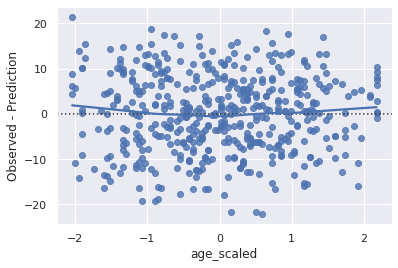

In [20]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = model.predict(x) - data.bounce_time
performance["age_scaled"] = data.age_scaled
performance["predicted"] = model.predict(x)

ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

Остатки намного лучше, чем раньше, более равномерно распределены по возрасту, и если мы посмотрим на прогнозы для каждого округа:

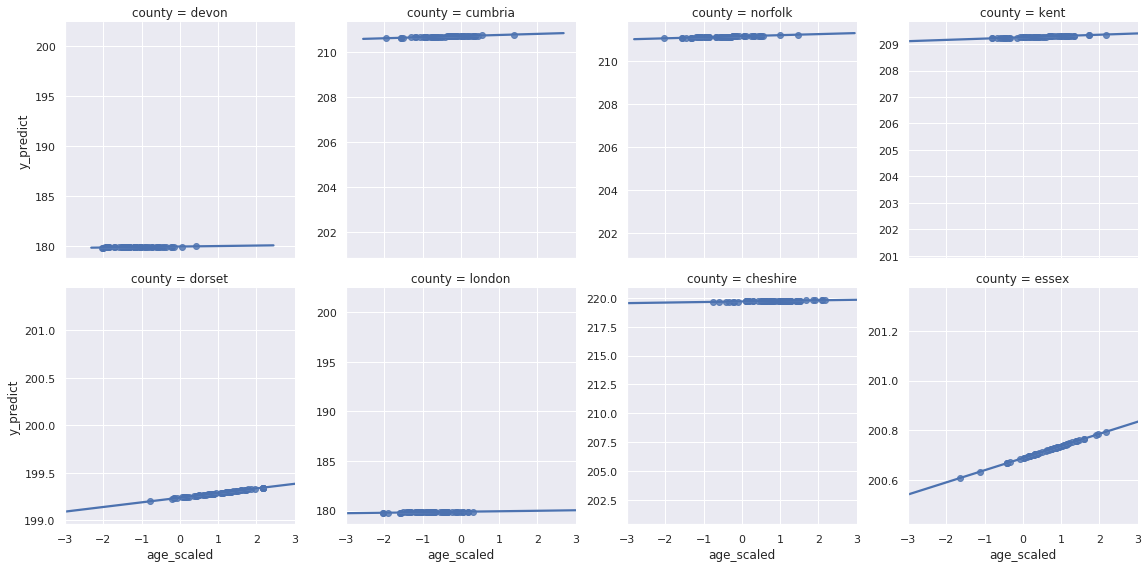

In [21]:
data_new["y_predict"] = model.predict(x)
grid = sns.lmplot(x = "age_scaled", y = "y_predict", col = "county", sharey=False, col_wrap = 4, data = data_new, height=4)
grid.set(xlim=(-3,3))

In [22]:
# and let's store the rmse
y_predict = model.predict(x)
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[1] = ["Fixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396


Теперь мы можем видеть, что коэффициент для градиента, заданного возрасту, существенно меньше и, вероятно, больше не является значимым. Давайте просто проверим это, составив таблицу коэффициентов:

In [23]:
# coefficient for age and the counties
pd.DataFrame.from_records(list(zip(np.concatenate((["age_scaled"],counties)), model.coef_)))

,0,1
0,age_scaled,0.048782
1,devon,-21.381957
2,cumbria,9.391460
3,norfolk,9.824419
4,kent,7.938668
5,dorset,-2.079637
6,london,-21.437323
7,cheshire,18.372916
8,essex,-0.628546


Но какую модель мы на самом деле поместили здесь? Это то, что мы хотели исследовать изначально? Модель также оценивает разницу во времени отказов между округами, и нас это на самом деле не интересует. Если это так, то это правильно, но компания веб-сайта просто хотела узнать, влияет ли возраст на время отказов. И, включив округ, мы это скрываем. Поэтому, чтобы посмотреть на влияние возраста на время отказов, нам необходимо контролировать различия между разными округами (а также между местами). Поэтому для этого мы должны рассматривать наши округа как случайные эффекты и строить модель смешанных эффектов!

# 4. Mixed effects models

Как мы уже говорили выше, модель со смешанными эффектами здесь идеальна, поскольку она позволяет нам использовать все имеющиеся у нас данные (больший размер выборки) и лучше распознавать корреляции между данными, поступающими из округов и мест. Мы также оценим меньшее количество параметров и избежим проблем с множественными сравнениями, которые могут возникнуть при использовании отдельных регрессий.

Таким образом, в этой модели мы рассматриваем наш возраст, который нас интересует, как фиксированный эффект, а округ и местоположение - как случайный эффект.

Но что это значит? Ну, это своего рода середина между предположением, что все наши коэффициенты для градиента и перехвата одинаковы (что мы делали в первой регрессии), и предположением, что они все независимы и различны. Если мы оглянемся назад на наши уравнения, теперь мы можем предположить, что, хотя b0 и b1 различны для каждого округа, все коэффициенты происходят из общего группового распределения, такого как нормальное распределение

Итак, теперь мы предполагаем, что перехваты b0 и градиенты b1 происходят из нормального распределения, центрированного вокруг среднего значения их соответствующей группы μ, с некоторым стандартным отклонением σ2, значения которого мы также оцениваем.

Фиксированное против случайного?
Итак, что делает переменную фиксированным или случайным эффектом. Хм, это сложно и есть много ответов там. Вкратце, мы рассматриваем фиксированные эффекты как переменные, которые нас интересуют. Мы хотели знать о возрасте, поэтому мы записали данные об этом и хотели посмотреть, как это повлияло на переменную отклика. Округ нас не интересовал, но мы записали его, поскольку знали, что наша методология выборки может привести к кластеризации наших данных, что может сделать недействительной линейную модель, существовавшую ранее. Если бы мы не записали, что кто-то, кому дали этот набор данных для анализа, возможно, неправильно сказал бы, что возраст является важным предиктором показателя отказов.  

Случайные эффекты часто являются нашими группами, которые мы пытаемся контролировать, например, округ в нашем примере. В частности, контроль за округами, когда мы не исчерпали всех доступных групп - у нас было только 8 округов в Англии. Если бы мы хотели сделать предсказания о графствах, то сначала попытались бы лучше их отобрать, а также рассматривать их как фиксированный эффект.  

Дальнейшее чтение для тех, кто хочет лучшего ответа!  

https://dynamicecology.wordpress.com/2015/11/04/is-it-a-fixed-or-random-effect/  

И посмотрите на обсуждение в документе, связанном с домашним заданием 3.  

Обучим наш смешанный эффект
Теперь мы подгоним нашу модель, используя библиотеку statsmodels. В этой исходной модели мы рассмотрим, как время выхода с сайта соотносится с масштабированным возрастом, контролируя влияние округов, допуская случайный перехват для каждой страны, т.е. мы говорим, что у каждого округа есть свой случайный перехват, но что склоны все те же по возрасту.

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# construct our model, with our county now shown as a group
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Likelihood:         -1733.0397 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.316    5.175 38.902 0.000 191.174 211.459
age_scaled    0.136    0.612  0.221 0.825  -1.065   1.336
Group Var   212.999   13.382                             



В этом кратком обзоре модели мы можем ясно видеть, что age_scaled оказывает более заметное влияние, чем в фиксированной модели ранее (коэффициент 0,136, а не 0,048), однако, что важно, он по-прежнему незначительно отличается от 0, с 95 % интервал для этого коэффициента, охватывающий -1,065 - 1,336.

И давайте посмотрим на прогнозы.

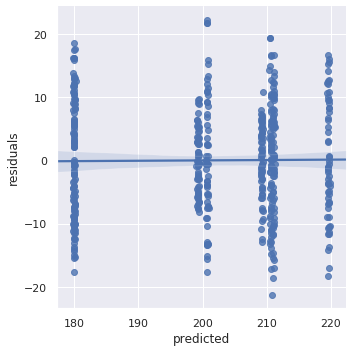

In [25]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance) #residuals - остатки

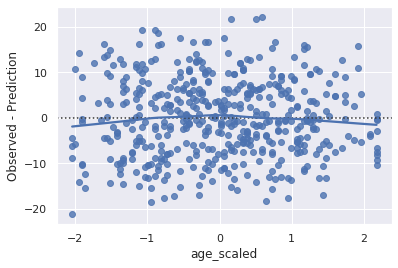

In [26]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [27]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[2] = ["Mixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948


Да, это странно - это очень похоже. На самом деле график остатков выглядит практически идентично предыдущему, где мы рассматривали округ как фиксированный эффект. Почему?

Хорошо, подумайте о том, что мы на самом деле только что реализовали. Все, что мы сделали, это скажем в последнем, что округ имеет случайный перехват, но тот же уклон. Это очень похоже на подход с фиксированным эффектом, когда округ был включен как термин, который будет влиять на перехват. Все, что мы изменили, - это то, что перехваты для каждого округа, вероятно, взяты из аналогичного распределения. Чтобы гарантировать, что у каждого округа есть свой собственный случайный уклон, мы должны включить это в нашу форум случайных эффектов, например так:

In [29]:
# construct our model, but this time we will have a random interecept AND a random slope with respect to age
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            8          Scale:                 72.8722    
Min. group size:       60         Likelihood:            -1733.3946 
Max. group size:       60         Converged:             Yes        
Mean group size:       60.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              202.140    8.356 24.190 0.000 185.762 218.518
age_scaled               0.161    1.196  0.134 0.893  -2.184   2.505
Group Var              558.143                                      
Group x age_scaled Cov -51.614                                      
age_scaled Var           8.621                    

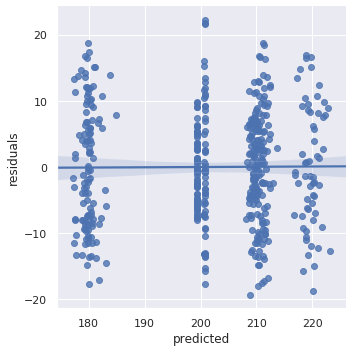

In [30]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

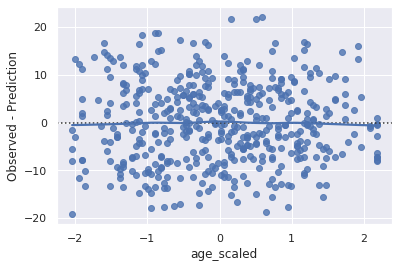

In [31]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [32]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[3] = ["Mixed_Random_Slopes", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948
3,Mixed_Random_Slopes,8.475248


Таким образом, наша смешанная модель со случайными уклонами теперь работает намного лучше, а наши остатки намного лучше распределяются. Важно отметить, что мы можем видеть, что возраст не влияет на показатель отказов, с доверительными интервалами для градиента по возрасту от -2,184 до 2,505 после того, как мы контролировали случайное изменение, вызванное округом должным образом, то есть со случайным наклоном и перехватить.

То, что мы увидели в наших данных, было то, что люди в некоторых странах занимали больше времени на веб-сайте, и что они также оказались старыми. Однако, чтобы получить это различие, мы должны были сначала рассматривать округ как случайный эффект. Но как насчет местоположения? А? Забыли об этом. Посмотрите материал 4. домой для этого.

# Домашняя работа  

1. Test the initial linear regression was significant   
In section 2 we constructed a linear regression model on our data. It looked as if the coefficient for the gradient was significant, i.e. there was in fact a positive relationship between age and bounce time. However, to be sure we could use a statistical test, such as the t.test to test this. This can be often useful and can be used to produce p.values which gives us a measure of how confident we are about something. In this we will test whether the intercept and mean are significantly different from 0.

In [33]:
from scipy import stats

# construct our linear regression model
lm = LinearRegression(fit_intercept=True)
x = data.age
y = data.bounce_time

# fit our model to the data
lm.fit(x[:, np.newaxis], y)

# let's get our fitted parameters for the intercept and coefficient and what our predictions are
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(x.values.reshape(-1, 1))

# and let's simulate some new data for the model and then compare what the error is for these 
newx = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
MSE = (sum((y-predictions)**2))/(len(newx)-len(newx.columns))

# and whats the variance, standard deviation, t values and p-values
var_b = MSE*(np.linalg.inv(np.dot(newx.T,newx)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newx)-1))) for i in ts_b]

# and let's group it together
names = ["intercept", "age"]
summary = pd.DataFrame()
summary["names"],summary["Coefficients"],summary["Standard Errors"] = [names,params,sd_b]
summary["t values"],summary["Probabilites"] = [ts_b,p_values]
print(summary)

       names  Coefficients  Standard Errors    t values  Probabilites
0  intercept    187.409130         1.659208  112.950956           0.0
1        age      0.275529         0.029959    9.196758           0.0


2. Рассчитать RMSE для отдельных линейных регрессий¶
В разделе 3 мы построили модели множественной линейной регрессии на наших данных. Но как они выступили? Попробуйте оценить RMSE для каждой модели.

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

model = LinearRegression(fit_intercept=True)
rms = np.empty(counties.size)
mse = np.empty(counties.size)

for i in range(counties.size):
    county = counties[i]
    x = data.age[data.county == county].values.reshape(-1,1)
    y = data.bounce_time[data.county == county]
    fit = model.fit(x, y)
    predict = model.predict(x)
    mse[i] = mean_squared_error(y, predict)
    rms[i] = sqrt(mse[i])

sqrt(mse.sum())

23.914852863665146

3. Добавьте места для модели смешанного эффекта  
В разделе 4 мы построили нашу модель смешанного эффекта, рассматривая округ как случайный эффект. Однако как насчет местоположения? Это действительно улучшит наши прогнозы.  

Подсказка: вам нужно будет создать новую переменную, которая будет учитывать, как вкладываются случайные эффекты. Например, нет ничего важного в местоположениях a, b и c, которые связывают местоположение a в Лондоне с местоположением в Эссексе. Поэтому явно вложите их

In [35]:
# construct our model, with our county now shown as a group
data["location_county"] = data["location"] + "_" + data["county"]
data.head()

md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["location_county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            24         Scale:                 23.7942    
Min. group size:       20         Likelihood:            -1504.9078 
Max. group size:       20         Converged:             Yes        
Mean group size:       20.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              201.491    3.448 58.441 0.000 194.734 208.249
age_scaled               0.151    0.393  0.385 0.700  -0.618   0.920
Group Var              282.769   21.275                             
Group x age_scaled Cov  -8.285    2.478                             
age_scaled Var           0.386    0.494           

In [36]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).mean())
results.loc[3] = ["Nested_Mixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948
3,Nested_Mixed,4.790668
